# Example for training Spiking CNN on subset of NMNIST digits

## The problem:
Training digit classifier(0-9) on a subset(1000 training and 100 testing) of NMNIST digit spikes recorded using DVS camera. Just chagne the training list to for full NMNIST training.

## Load proper paths for SLAYER Pytorch source modules

In [7]:
import sys, os
CODE_DIR = os.getcwd()
DATA_DIR = os.path.join(CODE_DIR, '../data')
RESULTS_DIR = os.path.join(CODE_DIR, '../results')
sys.path.append(CODE_DIR + "/slayerPytorch/src")

## Load required modules

SLAYER modules are available as `snn`
* The `spike-layer` module will be available as `snn.layer`.
* The `yaml-parameter` module will be availabe as `snn.params`.
* The `spike-loss` module will be available as `snn.loss`.
* The `spike-classifier` module will be available as `snn.predict`.
* The `spike-IO` module will be available as `snn.io`.


In [16]:
from datetime import datetime
import tqdm.notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import slayerSNN as snn
from learningStats import learningStats
from IPython.display import HTML
import zipfile
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torch.nn.functional as F

## Read SNN configuration from yaml file
See the file for all the configuration parameters. This configuration file will be used to describe the SNN. We will ignore the network configuration  describe in the yaml file here.

In [17]:
netParams = snn.params(os.path.join(CODE_DIR, 'network-moredata.yaml'))

In [18]:
netParams['training']

{'error': {'type': 'NumSpikes',
  'probSlidingWin': 20,
  'tgtSpikeRegion': {'start': 0, 'stop': 300},
  'tgtSpikeCount': {True: 60, False: 10}},
 'path': {'train': {'data': 'NMNIST/Train',
   'labels': 'NMNIST/Train/labels.txt'},
  'test': {'data': 'NMNIST/Test', 'labels': 'NMNIST/Test/labels.txt'}}}

# define base of spiking networks

## Defne the dataset class
The dataset definition follows standard PyTorch dataset definition.
Internally, it utilizes snn.io modules to read spikes and returns the spike in correct tensor format (CHWT).
* `datasetPath`: the path where the spike files are stored.
* `sampleFile`: the file that contains a list of sample indices and its corresponding clases.
* `samplingTime`: the sampling time (in ms) to bin the spikes.
* `sampleLength`: the length of the sample (in ms)

Note: This is a simple dataset class. A dataset that utilizes the folder hierarchy or xml list is easy to create.

## classifier datasets

## MNIST and MNIST->MNIST datasets

In [19]:
trainMNIST = torchvision.datasets.MNIST(
    root=os.path.join(DATA_DIR,'MNIST'),
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor())

In [20]:
testMNIST = torchvision.datasets.MNIST(
    root=os.path.join(DATA_DIR,'MNIST'),
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor())

In [21]:
# Dataset definition
class NMNIST_MNIST(Dataset):
    def __init__(self, MNIST, datasetPath, sampleFile, samplingTime, sampleLength):
        self.path = os.path.join(DATA_DIR, datasetPath)
        self.samples = np.loadtxt(os.path.join(DATA_DIR, sampleFile)).astype('int')
        self.samplingTime = samplingTime
        self.nTimeBins    = int(sampleLength / samplingTime)
        self.MNIST = MNIST

    def __getitem__(self, index):
        inputIndex  = self.samples[index, 0]
        classLabel  = self.samples[index, 1]

        inputSpikes = snn.io.read2Dspikes(
                        os.path.join(self.path, str(classLabel), format(inputIndex.item(), '05d') + '.bin')
                        ).toSpikeTensor(torch.zeros((2,34,34,self.nTimeBins)),
                        samplingTime=self.samplingTime)
#         sparseInputSpikes = torch.sparse_coo_tensor([inputSpikes.p, inputSpikes.y, inputSpikes.x, inputSpikes.t],
#                                                         np.ones_like(inputSpikes.p), (2, 34, 34, 306))

#         desiredClass = torch.zeros((10, 1, 1, 1))
#         desiredClass[classLabel,...] = 1
        return inputSpikes, self.MNIST[inputIndex-1][0].unsqueeze(-1)

    def __len__(self):
        return self.samples.shape[0]

In [22]:
trainNMNIST = NMNIST_MNIST(trainMNIST,
                           datasetPath =netParams['training']['path']['train']['data'], 
                            sampleFile  =netParams['training']['path']['train']['labels'],
                            samplingTime=netParams['simulation']['Ts'],
                            sampleLength=netParams['simulation']['tSample'])

In [23]:
testNMNIST = NMNIST_MNIST(testMNIST,
                          datasetPath =netParams['training']['path']['test']['data'], 
                            sampleFile  =netParams['training']['path']['test']['labels'],
                            samplingTime=netParams['simulation']['Ts'],
                            sampleLength=netParams['simulation']['tSample'])

## Visualize the spike data

In [24]:
spikes, image = testNMNIST[5234]
anim = snn.io.animTD(snn.io.spikeArrayToEvent(spikes.reshape((2, 34, 34, -1)).cpu().data.numpy()))
# anim = snn.io.animTD(snn.io.spikeArrayToEvent(input.to_dense().reshape((2, 34, 34, -1)).cpu().data.numpy()))
HTML(anim.to_jshtml())

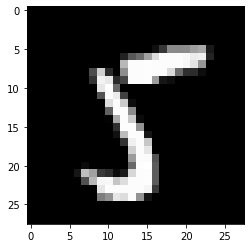

In [25]:
plt.imshow(image.numpy()[0,:,:,0], cmap='gray')

## Noisy data

In [26]:
# Delete the rogue temp-file
try:
    os.remove('None0000000.png')
except FileNotFoundError:
    pass

In [27]:
# Define the cuda device to run the code on.
# device = torch.device('cuda')
# Use multiple GPU's if available
device = torch.device('cuda:0')#:2') # should be the first GPU of deviceIDs 
deviceIds = [0]#2, 3]

## Define the network
The network definition follows similar style as standard PyTorch network definition, but it utilizes snn modules.

In [28]:
class SpikeToImageNMNIST(torch.nn.Module):
    def __init__(self, netParams=netParams):
        super(SpikeToImageNMNIST, self).__init__()
         # initialize slayer
        self.slayer = snn.layer(netParams['neuron'], netParams['simulation'])
        
        # Create snn loss instance.
        self.error = snn.loss(netParams).to(device)
        
        # define layers
        self.conv1 = self.slayer.conv(2, 4, 5, padding=2)
        self.conv2 = self.slayer.conv(4, 2, 3, padding=2)
        self.conv3 = self.slayer.conv(2, 1, 3)
        # "latent" layer
        self.conv4 = self.slayer.conv(1, 4, 3, padding=1)
        self.conv5 = self.slayer.conv(4, 2, 3, padding=1)
        
    def forward(self, x):
        x = self.slayer.spike(self.conv1(self.slayer.psp(x)))
        x = self.slayer.spike(self.conv2(self.slayer.psp(x)))
        x = self.slayer.spike(self.conv3(self.slayer.psp(x)))
        y = x # "latent" layer
        x = self.slayer.spike(self.conv4(self.slayer.psp(x)))
        x = self.slayer.spike(self.conv5(self.slayer.psp(x)))
        return y, x

# create instance of network, dataloaders, and optimizer

In [29]:
def numSpikesAnalogConv(self, spikeOut, desiredSpikes, numSpikesScale=1):
        '''
        Calculates spike loss based on number of spikes within a `target region`.
        The `target region` and `desired spike count` is specified in ``error.errorDescriptor['tgtSpikeRegion']``
        Any spikes outside the target region are penalized with ``error.spikeTime`` loss..

        .. math::
            e(t) &= 
            \\begin{cases}
            \\frac{acutalSpikeCount - desiredSpikeCount}{targetRegionLength} & \\text{for }t \in targetRegion\\\\
            \\left(\\varepsilon * (output - desired)\\right)(t) & \\text{otherwise}
            \\end{cases}
            
            E &= \\int_0^T e(t)^2 \\text{d}t

        Arguments:
            * ``spikeOut`` (``torch.tensor``): spike tensor
            * ``desiredClass`` (``torch.tensor``): one-hot encoded desired class tensor.
                Time dimension should be 1 and rest of the tensor dimensions should be same as ``spikeOut``.

        Usage:

        >>> loss = error.numSpikes(spikeOut, target)
        '''
        # Tested with autograd, it works
        assert self.errorDescriptor['type'] == 'NumSpikes', "Error type is not NumSpikes"
        # desiredClass should be one-hot tensor with 5th dimension 1
        tgtSpikeRegion = self.errorDescriptor['tgtSpikeRegion']
        tgtSpikeCount  = self.errorDescriptor['tgtSpikeCount']
        startID = np.rint( tgtSpikeRegion['start'] / self.simulation['Ts'] ).astype(int)
        stopID  = np.rint( tgtSpikeRegion['stop' ] / self.simulation['Ts'] ).astype(int)
        
        actualSpikes = torch.sigmoid(torch.sum(spikeOut[...,startID:stopID],
                                               dim=4, keepdim=True)/10-3.5) * self.simulation['Ts']
        #          .cpu().detach().numpy()
        # MNIST uses values from 0 to 1. Dividing by 10 and subtracting 3.5 then taking the sigmoid means
        # the center of the sigmoid will occur at around 35 spikes, and it will reach over 90% by 60 spikes,
        # and less than 10% by less than 10 spikes.
        
        # desiredSpikes = np.where(desiredClass.cpu() == True, tgtSpikeCount[True], tgtSpikeCount[False])
#         desiredSpikes = desiredSpikes.cpu().numpy()
        # print('actualSpikes :', actualSpikes.flatten())
        # print('desiredSpikes:', desiredSpikes.flatten())
#         print(actualSpikes.shape, desiredSpikes.shape)
        # print(actualSpikes.size(), desiredSpikes.size())
        errorSpikeCount = F.conv2d(actualSpikes.squeeze().unsqueeze(0),
                                   desiredSpikes.squeeze().unsqueeze(1), stride=1, groups=desiredSpikes.size()[0]) \
                            / (stopID - startID) * numSpikesScale
        peak  = torch.amax(errorSpikeCount, dim=(2,3))
        total = torch.sum(errorSpikeCount, dim=(2,3))
        error = total-peak
        # print(errorSpikeCount.size())
#         print(errorSpikeCount.shape)
#         targetRegion = np.zeros(spikeOut.shape)
#         targetRegion[:,:,:,:,startID:stopID] = 1;
#         spikeDesired = torch.FloatTensor(targetRegion * spikeOut.cpu().data.numpy()).to(spikeOut.device)
        
        # error = self.psp(spikeOut - spikeDesired)
#         error = self.slayer.psp(spikeOut - spikeDesired)
#         error += torch.FloatTensor(errorSpikeCount * targetRegion).to(spikeOut.device)
        
        return 1/2 * torch.sum(error**2) * self.simulation['Ts']

In [30]:
# Instantiate network
net = SpikeToImageNMNIST()
device = torch.device("cuda:0") # for training on GPU
net = net.to(device) # move it to device

# Dataset and dataLoader instances.
trainingSet = trainNMNIST
trainingsubset = torch.LongTensor(6000).random_(0, len(trainingSet))
trainLoader = DataLoader(dataset=trainingSet, batch_size=8, # shuffle=True,
                         sampler=torch.utils.data.SubsetRandomSampler(trainingsubset),
                         num_workers=4)

testingSet = testNMNIST
testingsubset = torch.LongTensor(10).random_(0, len(testingSet))
testLoader = DataLoader(dataset=testingSet, batch_size=10, # shuffle=True, 
                        sampler=torch.utils.data.SubsetRandomSampler(testingsubset),
                        num_workers=4)

# Set the loss function
error = snn.loss(netParams).to(device)

# Define optimizer module.
optimizer = torch.optim.Adam(net.parameters(), lr = 0.01, amsgrad = True)

In [31]:
spikes, image = trainingSet[0]
spikes = spikes.unsqueeze(0).to(device)
image = image.unsqueeze(0).to(device)

output = net(spikes)
output[0].size(), output[1].size()

(torch.Size([1, 1, 34, 34, 300]), torch.Size([1, 2, 34, 34, 300]))

# Train it!

In [33]:
# Create writer for logging to tensorboard
writer = SummaryWriter(os.path.join(RESULTS_DIR, 'trainingstats', 'spiketoimagetospike2', 'model1'))

# epoch loop.
for epoch in tqdm.trange(100, desc='epochs'):
        # Reset training stats.
#         stats.training.reset()
#         tSt = datetime.now()
#         trainCorrectSamples = 0
#         trainNumSamples = 0
        trainLoss = 0
        # Training loop.
        for i, (spikes, image) in enumerate(tqdm.tqdm(trainLoader, desc='training loop', leave=False), 0):
            # Move the input and target to correct GPU.
            spikes = spikes.to(device)
            image  = image.to(device)

            # Forward pass of the network.
            intermediate, output = net.forward(spikes)
            
#             print(output.size(), image.size())

            # Gather the training stats.
#             trainCorrectSamples += torch.sum( snn.predict.getClass(output) == label ).data.item()
#             trainNumSamples     += len(label)

            # Calculate loss.
            loss1 = numSpikesAnalogConv(error, intermediate, image) # intermediate layer should look like image
            loss2 = torch.sum((spikes-output)**2) # output should be same as input
            loss = loss1+loss2
            
            # Reset gradients to zero.
            optimizer.zero_grad()

            # Backward pass of the network.
            loss.backward()

            # Update weights.
            optimizer.step()

            # Gather training loss stats.
            trainLoss += loss.cpu().data.item()

            # Display training stats. (Suitable for normal python implementation)
            # stats.print(epoch, i, (datetime.now() - tSt).total_seconds())

            

            if i%100 == 0:
                # Update training stats.
#                 try: stats.training.update()
#                 except TypeError: print('train acc should be 0', TypeError)
                # Reset testing stats.
#                 stats.testing.reset()
                
                testLoss = 0
                
                # Testing loop.
                # Same steps as Training loops except loss backpropagation and weight update.
                
                # for i, (spikes, image) in tqdm.tqdm(enumerate(testLoader, 0), desc='testing loop', leave=False):
                spikes, image = next(iter(trainLoader))
                spikes = spikes.to(device)
                image = image.to(device)
                intermediate, output = net.forward(spikes)

                # testCorrectSamples += torch.sum( snn.predict.getClass(output) == label ).data.item()
                # testNumSamples     += len(label)

                loss1 = numSpikesAnalogConv(error, intermediate, image) # intermediate layer should look like image
                loss2 = torch.sum((spikes-output)**2) # output should be same as input
                loss = loss1+loss2
                testLoss += loss.cpu().data.item()
                writer.add_scalar('Loss/train',     trainLoss,     epoch+i/len(trainLoader))
                writer.add_scalar('Loss/test',      testLoss,      epoch+i/len(trainLoader))

                # display sample output in tensorboard
                spikegrid = torchvision.utils.make_grid(intermediate.sum(dim=4)) # output spikes summed in time
                mnistgrid = torchvision.utils.make_grid(image.squeeze(dim=4)) # all mnist images in the batch
                writer.add_image('Middle/Total intermediate spikes', spikegrid, epoch+i/len(trainLoader))
                writer.add_image('Middle/MNIST refrence', mnistgrid, epoch+i/len(trainLoader))
                
                outspikegrid  = torchvision.utils.make_grid(
                                    output[...,:50].sum(dim=4)[:,1]-output[...,:50].sum(dim=4)[:,0])
                truespikegrid = torchvision.utils.make_grid(
                                    spikes[...,:50].sum(dim=4)[:,1]-spikes[...,:50].sum(dim=4)[:,0])
                writer.add_image('Spikes/Total output (first 50 bins)', spikegrid, epoch+i/len(trainLoader))
                writer.add_image('Spikes/Total input (first 50 bins)', mnistgrid, epoch+i/len(trainLoader))
                # stats.print(epoch, i)
                
                
                # Update testing stats.
#                 try: stats.testing.update()
#                 except TypeError: print('test acc should be 0?', TypeError)
#                 writer.add_scalar('Accuracy/train', stats.training.accuracy() or 0, epoch+i/60000)
#                 writer.add_scalar('Accuracy/test',  stats.testing.accuracy() or 0,  epoch+i/60000)
                
                
                

                # Reset training stats.
#                 stats.training.reset()
writer.close()

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

In [340]:
spikes, image = next(iter(trainLoader))
spikes = spikes.to(device)
output = net.forward(spikes)

# testCorrectSamples += torch.sum( snn.predict.getClass(output) == label ).data.item()
# testNumSamples     += len(label)

loss = net.error.numSpikes(output, image)
testLoss += loss.cpu().data.item()

# display sample output in tensorboard
spikegrid = torchvision.utils.make_grid(output.sum(dim=4)) # output spikes summed in time
mnistgrid = torchvision.utils.make_grid(image.squeeze(dim=4)) # all mnist images in the batch

writer.add_image('Total spikes', spikegrid, epoch+i/len(trainLoader))
writer.add_image('MNIST refrence', mnistgrid, epoch+i/len(trainLoader))
writer.add_scalar('Loss/train',     trainLoss,     epoch+i/len(trainLoader))
writer.add_scalar('Loss/test',      testLoss,      epoch+i/len(trainLoader))

In [349]:
np.histogram(output.sum(dim=4).squeeze().cpu().detach().numpy())

(array([6260,    4,    3,    1,    0,    1,    0,    1,    1,    1]),
 array([ 0. ,  3.2,  6.4,  9.6, 12.8, 16. , 19.2, 22.4, 25.6, 28.8, 32. ],
       dtype=float32))

In [350]:
np.histogram(image)

(array([5110,   74,   54,   72,   83,   49,   74,   55,  101,  600]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32))

# create networks

In [118]:
Network0 = SpikingNetwork()
slayer = Network0.slayer
Network0.setLayers([
            slayer.conv(2, 10, 5, padding=1),
            slayer.conv(10, 20, 3, padding=1),
            slayer.conv(20, 10, 3, padding=1),
            slayer.conv(10, 5, 3, padding=1),
            slayer.conv(5, 1, 3, padding=1)
        ])

In [45]:
Network1 = SpikingNetwork()
slayer = Network1.slayer
Network1.setLayers([
            slayer.conv(2, 6, 5, padding=1),
            slayer.pool(2),
            slayer.conv(6, 12, 3, padding=1),
            slayer.pool(2),
            slayer.conv(12, 12, 3, padding=1),
            slayer.dense((8,8,12), 10)
        ])

In [127]:
Network0.readyTraining()

TypeError: readyTraining() missing 2 required positional arguments: 'device' and 'deviceIds'

In [126]:
Network0(trainNMNIST[0][0])

RuntimeError: input.type().is_cuda() INTERNAL ASSERT FAILED at src/cuda/slayerKernels.cu:43, please report a bug to PyTorch. input must be a CUDA tensor (convCuda at src/cuda/slayerKernels.cu:43)
frame #0: c10::Error::Error(c10::SourceLocation, std::string const&) + 0x47 (0x7fc348981627 in /home/rrs/anaconda3/envs/snn3/lib/python3.7/site-packages/torch/lib/libc10.so)
frame #1: convCuda(at::Tensor, at::Tensor, float) + 0x57b (0x7fc32e7ec4bb in /home/rrs/anaconda3/envs/snn3/lib/python3.7/site-packages/slayerCuda-0.0.0-py3.7-linux-x86_64.egg/slayerCuda.cpython-37m-x86_64-linux-gnu.so)
frame #2: <unknown function> + 0x2ad9d (0x7fc32e806d9d in /home/rrs/anaconda3/envs/snn3/lib/python3.7/site-packages/slayerCuda-0.0.0-py3.7-linux-x86_64.egg/slayerCuda.cpython-37m-x86_64-linux-gnu.so)
frame #3: <unknown function> + 0x26965 (0x7fc32e802965 in /home/rrs/anaconda3/envs/snn3/lib/python3.7/site-packages/slayerCuda-0.0.0-py3.7-linux-x86_64.egg/slayerCuda.cpython-37m-x86_64-linux-gnu.so)
frame #4: _PyMethodDef_RawFastCallKeywords + 0x274 (0x5588884a7914 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #5: _PyCFunction_FastCallKeywords + 0x21 (0x5588884a7a31 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #6: _PyEval_EvalFrameDefault + 0x4e1d (0x558888513ebd in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #7: _PyFunction_FastCallDict + 0x10b (0x55888845785b in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #8: THPFunction_apply(_object*, _object*) + 0xa0f (0x7fc3800b9a3f in /home/rrs/anaconda3/envs/snn3/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #9: _PyMethodDef_RawFastCallKeywords + 0x1e4 (0x5588884a7884 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #10: _PyCFunction_FastCallKeywords + 0x21 (0x5588884a7a31 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #11: _PyEval_EvalFrameDefault + 0x4e1d (0x558888513ebd in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #12: _PyFunction_FastCallKeywords + 0xfb (0x5588884a6e7b in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #13: _PyEval_EvalFrameDefault + 0x4a89 (0x558888513b29 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #14: _PyFunction_FastCallDict + 0x10b (0x55888845785b in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #15: _PyObject_Call_Prepend + 0x63 (0x5588884764d3 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #16: PyObject_Call + 0x6e (0x558888468ffe in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #17: _PyEval_EvalFrameDefault + 0x1e4a (0x558888510eea in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #18: _PyEval_EvalCodeWithName + 0x2f9 (0x558888456829 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #19: _PyFunction_FastCallDict + 0x1d5 (0x558888457925 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #20: _PyObject_Call_Prepend + 0x63 (0x5588884764d3 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #21: <unknown function> + 0x16be1a (0x5588884ade1a in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #22: _PyObject_FastCallKeywords + 0x48b (0x5588884aeccb in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #23: _PyEval_EvalFrameDefault + 0x49e6 (0x558888513a86 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #24: _PyFunction_FastCallDict + 0x10b (0x55888845785b in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #25: _PyObject_Call_Prepend + 0x63 (0x5588884764d3 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #26: PyObject_Call + 0x6e (0x558888468ffe in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #27: _PyEval_EvalFrameDefault + 0x1e4a (0x558888510eea in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #28: _PyEval_EvalCodeWithName + 0x2f9 (0x558888456829 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #29: _PyFunction_FastCallDict + 0x1d5 (0x558888457925 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #30: _PyObject_Call_Prepend + 0x63 (0x5588884764d3 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #31: <unknown function> + 0x16be1a (0x5588884ade1a in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #32: _PyObject_FastCallKeywords + 0x48b (0x5588884aeccb in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #33: _PyEval_EvalFrameDefault + 0x52fe (0x55888851439e in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #34: _PyFunction_FastCallDict + 0x10b (0x55888845785b in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #35: _PyObject_Call_Prepend + 0x63 (0x5588884764d3 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #36: PyObject_Call + 0x6e (0x558888468ffe in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #37: _PyEval_EvalFrameDefault + 0x1e4a (0x558888510eea in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #38: _PyEval_EvalCodeWithName + 0x2f9 (0x558888456829 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #39: _PyFunction_FastCallDict + 0x1d5 (0x558888457925 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #40: _PyObject_Call_Prepend + 0x63 (0x5588884764d3 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #41: <unknown function> + 0x16be1a (0x5588884ade1a in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #42: _PyObject_FastCallKeywords + 0x48b (0x5588884aeccb in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #43: _PyEval_EvalFrameDefault + 0x49e6 (0x558888513a86 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #44: _PyEval_EvalCodeWithName + 0x2f9 (0x558888456829 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #45: PyEval_EvalCodeEx + 0x44 (0x558888457714 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #46: PyEval_EvalCode + 0x1c (0x55888845773c in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #47: <unknown function> + 0x1dcf1d (0x55888851ef1d in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #48: _PyMethodDef_RawFastCallKeywords + 0xe9 (0x5588884a7789 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #49: _PyCFunction_FastCallKeywords + 0x21 (0x5588884a7a31 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #50: _PyEval_EvalFrameDefault + 0x46f5 (0x558888513795 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #51: _PyGen_Send + 0x2a2 (0x5588884af982 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #52: _PyEval_EvalFrameDefault + 0x1a84 (0x558888510b24 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #53: _PyGen_Send + 0x2a2 (0x5588884af982 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #54: _PyEval_EvalFrameDefault + 0x1a84 (0x558888510b24 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #55: _PyGen_Send + 0x2a2 (0x5588884af982 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #56: _PyMethodDef_RawFastCallKeywords + 0x8d (0x5588884a772d in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #57: _PyMethodDescr_FastCallKeywords + 0x4f (0x5588884ae7af in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #58: _PyEval_EvalFrameDefault + 0x4bdc (0x558888513c7c in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #59: _PyFunction_FastCallKeywords + 0xfb (0x5588884a6e7b in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #60: _PyEval_EvalFrameDefault + 0x416 (0x55888850f4b6 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #61: _PyFunction_FastCallKeywords + 0xfb (0x5588884a6e7b in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #62: _PyEval_EvalFrameDefault + 0x6a0 (0x55888850f740 in /home/rrs/anaconda3/envs/snn3/bin/python)
frame #63: _PyEval_EvalCodeWithName + 0x2f9 (0x558888456829 in /home/rrs/anaconda3/envs/snn3/bin/python)


In [46]:
Network0.readyTraining(device, deviceIds)

In [47]:
len(Network0.netVars['testLoader'])

125

# Train the network
Train the network for 100 epochs.

In [49]:
# first move to a new directory to not overwrite anything
dt_string = datetime.now().strftime("%d-%m-%Y_%Hh%Mm%S")
dirname = dt_string
i = 0
while os.path.exists(os.path.join(RESULTS_DIR, 'data', dirname)):
    dirname = dt_string + '_' + str(++i)
os.mkdir(os.path.join(RESULTS_DIR, 'data', dirname))

In [50]:
Network0.readyTraining(device, deviceIds)
Network0.doTrain(device, epochcount=20, writer=SummaryWriter(os.path.join(RESULTS_DIR,'data',dirname,"moredata")))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

In [51]:
os.makedirs(os.path.join(RESULTS_DIR, 'models', dirname, 'moredata'))

In [52]:
torch.save(Network0.state_dict(), os.path.join(RESULTS_DIR, 'models', dirname, 'moredata', 'originalmodel'))

In [ ]:
Network1.readyTraining(device, deviceIds)
Network1.doTrain(device, epochcount=20, writer=SummaryWriter(os.path.join(RESULTS_DIR,'data',dirname,"moredata2")))

In [ ]:
os.makedirs(os.path.join(RESULTS_DIR, 'models', dirname, 'moredata2'))

In [ ]:
torch.save(Network1.state_dict(), os.path.join(RESULTS_DIR, 'models', dirname, 'moredata2', 'model1'))

# testing newly trained network with old testing set to make sure accuracy results are valid and comparable

In [68]:
netParamsOld = snn.params('network.yaml')

In [59]:
with zipfile.ZipFile('../data/NMNISTsmall.zip') as zip_file:
    for member in zip_file.namelist():
        if not os.path.exists('./' + member):
            zip_file.extract(member, '../data/')

In [60]:
# Dataset definition
class nmnistDatasetOld(Dataset):
    def __init__(self, datasetPath, sampleFile, samplingTime, sampleLength):
        self.path = datasetPath 
        self.samples = np.loadtxt(sampleFile).astype('int')
        self.samplingTime = samplingTime
        self.nTimeBins    = int(sampleLength / samplingTime)

    def __getitem__(self, index):
        inputIndex  = self.samples[index, 0]
        classLabel  = self.samples[index, 1]

        inputSpikes = snn.io.read2Dspikes(
                        self.path + str(inputIndex.item()) + '.bs2'
                        ).toSpikeTensor(torch.zeros((2,34,34,self.nTimeBins)),
                        samplingTime=self.samplingTime)
        desiredClass = torch.zeros((10, 1, 1, 1))
        desiredClass[classLabel,...] = 1
        return inputSpikes, desiredClass, classLabel

    def __len__(self):
        return self.samples.shape[0]

In [67]:
net = Network0.netVars['net']
stats = Network0.netVars['stats']
error = Network0.netVars['error']

In [69]:
testingSet = nmnistDatasetOld(datasetPath  =netParamsOld['training']['path']['in'], 
                            sampleFile  =netParamsOld['training']['path']['test'],
                            samplingTime=netParamsOld['simulation']['Ts'],
                            sampleLength=netParamsOld['simulation']['tSample'])
testLoader = DataLoader(dataset=testingSet, batch_size=8, shuffle=False, num_workers=4)

In [70]:
# Reset testing stats.
stats.testing.reset()

# Testing loop.
# Same steps as Training loops except loss backpropagation and weight update.
for i, (input, target, label) in enumerate(tqdm.tqdm(testLoader, desc='test'), 0):
    input  = input.to(device)
    target = target.to(device) 

    output = net.forward(input)

    stats.testing.correctSamples += torch.sum( snn.predict.getClass(output) == label ).data.item()
    stats.testing.numSamples     += len(label)

    loss = error.numSpikes(output, target)
    stats.testing.lossSum += loss.cpu().data.item()
    # stats.print(epoch, i)

# Update testing stats.
stats.testing.update()

In [71]:
stats.print(0, 0)


Epoch :          0(i =       0)
loss = 1.0278      (min = 0.51917    )    accuracy = 0.87023  (max = 1       )
loss = 0.9149      (min = 0.9149     )    accuracy = 0.88     (max = 0.88    )


## ~~Plot the Results~~